Two-class classification, or binary classification, may be the most widely applied kind of machine learning problem. In this example, we will learn to classify movie reviews into "positive" reviews and "negative" reviews, just based on the text content of the reviews.


In [14]:
import keras
keras.__version__


'2.3.1'

In [15]:
NUM_WORDS=1000 # only use top 1000 words
INDEX_FROM=3   # word index offset

We'll be working with "IMDB dataset", a set of 50,000 highly-polarized reviews from the Internet Movie Database. They are split into 25,000 reviews for training and 25,000 reviews for testing, each set consisting in 50% negative and 50% positive reviews.


In [16]:
from keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=NUM_WORDS,index_from=INDEX_FROM)

The argument num_words=10000 means that we will only keep the top 10,000 most frequently occurring words in the training data. Rare words will be discarded.

The variables train_data and test_data are lists of reviews, each review being a list of word indices (encoding a sequence of words). train_labels and test_labels are lists of 0s and 1s, where 0 stands for "negative" and 1 stands for "positive":

In [17]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 2,
 2,
 65,
 458,
 2,
 66,
 2,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 2,
 2,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2,
 19,
 14,
 22,
 4,
 2,
 2,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 2,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2,
 2,
 16,
 480,
 66,
 2,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 2,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 2,
 15,
 256,
 4,
 2,
 7,
 2,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 2,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2,
 56,
 26,
 141,
 6,
 194,
 2,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 2,
 18,
 51,
 36,
 28,
 224,
 92,
 25,
 104,
 4,
 226,
 65,
 16,
 3

In [18]:
train_labels[0]

1

In [19]:

max([max(sequence) for sequence in train_data])

999

Let us quickly decode one of these reviews back to English words

In [20]:
word_index=imdb.get_word_index()
word_index={k:(v+INDEX_FROM) for k,v in word_index.items()}
word_index["<PAD>"]=0
word_index["<START>"]=1
word_index["<UNK>"]=2
word_index["<UNUSED>"]=3

id_to_word={value:key for key,value in word_index.items()}
print(' '.join(id_to_word[id] for id in train_data[0] ))

1646592/1641221 [==============================] - 2s 1us/step
<START> this film was just brilliant casting <UNK> <UNK> story direction <UNK> really <UNK> the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same <UNK> <UNK> as myself so i loved the fact there was a real <UNK> with this film the <UNK> <UNK> throughout the film were great it was just brilliant so much that i <UNK> the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the <UNK> <UNK> was amazing really <UNK> at the end it was so sad and you know what they say if you <UNK> at a film it must have been good and this definitely was also <UNK> to the two little <UNK> that played the <UNK> of <UNK> and paul they were just brilliant children are often left out of the <UNK> <UNK> i think because the stars that play them all <UNK> up are such a big <UNK> for the whole film but these children a

## Preparing the data

We cannot feed lists of integers into a neural network. We have to turn our lists into tensors. There are two ways we could do that:

We could pad our lists so that they all have the same length, and turn them into an integer tensor of shape (samples, word_indices), then use as first layer in our network a layer capable of handling such integer tensors (the Embedding layer, which we will cover in detail later in the book).

We could one-hot-encode our lists to turn them into vectors of 0s and 1s. Concretely, this would mean for instance turning the sequence [3, 5] into a 10,000-dimensional vector that would be all-zeros except for indices 3 and 5, which would be ones. Then we could use as first layer in our network a Dense layer, capable of handling floating point vector data.
We will go with
the latter solution. Let's vectorize our data, which we will do manually for maximum clarity:



In [22]:
import numpy as np

In [23]:
def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

In [24]:
x_train=vectorize_sequences(train_data)
x_test=vectorize_sequences(test_data)

In [25]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [26]:
x_test[0]

array([0., 1., 1., ..., 0., 0., 0.])

Now let us vectorize our labels

In [27]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

## Building the neural network

We make the following architecture choice: 

Two intermediate layers with 16 hidden units each, and a third layer which will output the scalar prediction regarding the sentiment of the current review. 

The intermediate layers will use relu as their "activation function", and the final layer will use a sigmoid activation so as to output a probability (a score between 0 and 1, indicating how likely the sample is to have the target "1", i.e. how likely the review is to be positive). 

In [35]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


In [36]:
#model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

In [38]:
#from keras import optimizers

#model.compile(optimizer=optimizers.RMSprop(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [45]:
from keras import losses
from keras import metrics

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

## Validation set

In order to monitor during training the accuracy of the model on data that it has never seen before, we will create a "validation set" by setting apart 10,000 samples from the original training data.

In [46]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

We will now train our model for 20 epochs (20 iterations over all samples in the x_train and y_train tensors), in mini-batches of 512 samples. At this same time we will monitor loss and accuracy on the 10,000 samples that we set apart. This is done by passing the validation data as the validation_data argument.

In [47]:
history = model.fit(partial_x_train,partial_y_train,epochs=20,batch_size=512,validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 2s 104us/step - loss: 0.2608 - binary_accuracy: 0.8922 - val_loss: 0.3551 - val_binary_accuracy: 0.8567
Epoch 2/20
15000/15000 [==============================] - 1s 93us/step - loss: 0.2442 - binary_accuracy: 0.9017 - val_loss: 0.3549 - val_binary_accuracy: 0.8570
Epoch 3/20
15000/15000 [==============================] - 1s 91us/step - loss: 0.2416 - binary_accuracy: 0.9021 - val_loss: 0.3813 - val_binary_accuracy: 0.8423
Epoch 4/20
15000/15000 [==============================] - 1s 92us/step - loss: 0.2385 - binary_accuracy: 0.9029 - val_loss: 0.3745 - val_binary_accuracy: 0.8500
Epoch 5/20
15000/15000 [==============================] - 1s 92us/step - loss: 0.2306 - binary_accuracy: 0.9051 - val_loss: 0.3582 - val_binary_accuracy: 0.8532
Epoch 6/20
15000/15000 [==============================] - 1s 90us/step - loss: 0.2261 - binary_accuracy: 0.9099 - val_loss: 0.3707 - val_binary_

In [48]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])

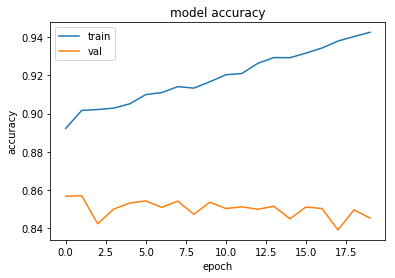

In [49]:
from matplotlib import pyplot as plt
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

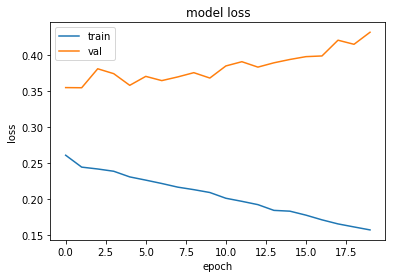

In [50]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

As you can see, the training loss decreases with every epoch and the training accuracy increases with every epoch. That's what you would expect when running gradient descent optimization -- the quantity you are trying to minimize should get lower with every iteration. But that isn't the case for the validation loss and accuracy: they seem to peak at the fourth epoch. This is an example of what we were warning against earlier: a model that performs better on the training data isn't necessarily a model that will do better on data it has never seen before. In precise terms, what you are seeing is "overfitting": after the second epoch, we are over-optimizing on the training data, and we ended up learning representations that are specific to the training data and do not generalize to data outside of the training set.

In this case, to prevent overfitting, we could simply stop training after three epochs.

In [ ]:

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
17408/25000 [===================>..........] - ETA: 0s - loss: 0.5430 - accuracy: 0.7592